In [3]:
!pip install networkx

     ---------------------------------------- 2.0/2.0 MB 1.3 MB/s eta 0:00:00


In [1]:
import wikipedia as wp

ds = wp.page("data science")


In [17]:
#@title
# Data manipulation
import pandas as pd
import random

# Wikipedia API
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError

# Plotting
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
ds

<WikipediaPage 'Data science'>

In [4]:
print(wp.summary("data science")[:100])

Data science is an interdisciplinary academic field 
that uses statistics, scientific computing, sci


In [6]:
wp.page("data science").links

['Academic discipline',
 'Algorithm',
 'American Statistical Association',
 'Analysis',
 'Andrew Gelman',
 'Astronomical survey',
 'Basic research',
 'Ben Fry',
 'Big data',
 'Boston',
 'Boston Globe',
 'Business',
 'Buzzword',
 'C. F. Jeff Wu',
 'Columbia University',
 'Comet NEOWISE',
 'Committee on Data for Science and Technology',
 'Communication',
 'Complex systems',
 'Computational science',
 'Computer science',
 'DJ Patil',
 'Data',
 'Data (computing)',
 'Data analysis',
 'Data archaeology',
 'Data augmentation',
 'Data cleansing',
 'Data collection',
 'Data compression',
 'Data corruption',
 'Data curation',
 'Data degradation',
 'Data editing',
 'Data extraction',
 'Data farming',
 'Data format management',
 'Data fusion',
 'Data integration',
 'Data integrity',
 'Data library',
 'Data lineage',
 'Data loading',
 'Data loss',
 'Data management',
 'Data migration',
 'Data mining',
 'Data philanthropy',
 'Data pre-processing',
 'Data preservation',
 'Data publishing',
 'Data qua

In [28]:
(wp.page("data science").links)


{'Academic discipline',
 'Algorithm',
 'American Statistical Association',
 'Analysis',
 'Andrew Gelman',
 'Astronomical survey',
 'Basic research',
 'Ben Fry',
 'Big data',
 'Boston',
 'Boston Globe',
 'Business',
 'Buzzword',
 'C. F. Jeff Wu',
 'Columbia University',
 'Comet NEOWISE',
 'Committee on Data for Science and Technology',
 'Communication',
 'Complex systems',
 'Computational science',
 'Computer science',
 'DJ Patil',
 'Data',
 'Data (computing)',
 'Data analysis',
 'Data archaeology',
 'Data augmentation',
 'Data cleansing',
 'Data collection',
 'Data compression',
 'Data corruption',
 'Data curation',
 'Data degradation',
 'Data editing',
 'Data extraction',
 'Data farming',
 'Data format management',
 'Data fusion',
 'Data integration',
 'Data integrity',
 'Data library',
 'Data lineage',
 'Data loading',
 'Data loss',
 'Data management',
 'Data migration',
 'Data mining',
 'Data philanthropy',
 'Data pre-processing',
 'Data preservation',
 'Data publishing',
 'Data qua

In [29]:
set??

Init signature: set(self, /, *args, **kwargs)
Docstring:     
set() -> new empty set object
set(iterable) -> new set object

Build an unordered collection of unique elements.
Type:           type
Subclasses:     LazySet, LazySet, LazySet


In [27]:
weight_test = 0.1
link_test=wp.page("data science").content.lower().count("algorithm")
weight_test += link_test

weight_test

2.1

In [30]:
#@title
class RelationshipGenerator():
    """Generates relationships between terms, based on wikipedia links"""

    def __init__(self):
        """Links are directional, start + end, they should also have a weight"""
        self.links = []  # [start, end, weight]

    def scan(self, start=None, repeat=0):
        """Start scanning from a specific word, or from internal database
        
        Args:
            start (str): the term to start searching from, can be None to let
                algorithm decide where to start
            repeat (int): the number of times to repeat the scan
        """
        while repeat >= 0:

            # should check if start page exists
            # and haven't already scanned
            if start in [l[0] for l in self.links]:
                raise Exception("Already scanned")

            term_search = True if start is not None else False

            # If a start isn't defined, we should find one
            if start is None:
                start = self.find_starting_point()

            # Scan the starting point specified for links
            print(f"Scanning page {start}...")
            try:
                # Fetch the page through the Wikipedia API
                page = wp.page(start)
                links = list(set(page.links))
                # ignore some uninteresting terms
                links = [l for l in links if not self.ignore_term(l)]

                # Add links to database
                link_weights = []
                for link in links:
                    weight = self.weight_link(page, link)
                    link_weights.append(weight)

                # Summarise the weights, so that the highest weight is 1, and the lowest is 0
                link_weights = [w / max(link_weights) for w in link_weights]

                for i, link in enumerate(links):
                    # +3 vs +1 works pretty well in providing weightage to the summary terms
                    self.links.append(
                        [start, link.lower(), link_weights[i] + 2 * int(term_search)])

                # Print some data to the user on progress
                explored_nodes = set([l[0] for l in self.links])
                explored_nodes_count = len(explored_nodes)
                total_nodes = set([l[1] for l in self.links])
                total_nodes_count = len(total_nodes)
                new_nodes = [l.lower() for l in links if l not in total_nodes]
                new_nodes_count = len(new_nodes)
                print(
                    f"New nodes added: {new_nodes_count}, Total Nodes: {total_nodes_count}, Explored Nodes: {explored_nodes_count}")

            except (DisambiguationError, PageError):
                # This happens if the page has disambiguation or doesn't exist
                # We just ignore the page for now, could improve this
                self.links.append([start, "DISAMBIGUATION", 0])

            repeat -= 1
            start = None

    def find_starting_point(self):
        """Find the best place to start when no input is given"""
        # Need some links to work with.
        if len(self.links) == 0:
            raise Exception(
                "Unable to start, no start defined or existing links")

        # Get top terms
        res = self.rank_terms()
        sorted_links = list(zip(res.index, res.values))
        all_starts = set([l[0] for l in self.links])

        # Remove identifiers (these are on many Wikipedia pages)
        all_starts = [l for l in all_starts if '(identifier)' not in l]

        # print(sorted_links[:10])
        # Iterate over the top links, until we find a new one
        for i in range(len(sorted_links)):
            if sorted_links[i][0] not in all_starts and len(sorted_links[i][0]) > 0:
                return sorted_links[i][0]

        # no link found
        raise Exception("No starting point found within links")
        return

    @staticmethod
    def weight_link(page, link):
        """Weight an outgoing link for a given source page
        
        Args:
            page (obj): 
            link (str): the outgoing link of interest
        
        Returns:
            (float): the weight, for each link
        """
        weight = 0.1

        link_counts = page.content.lower().count(link.lower())
        weight += link_counts

        if link.lower() in page.summary.lower():
            weight += 3

        return weight

    def get_database(self):
        return sorted(self.links, key=lambda x: -x[2])

    def rank_terms(self, with_start=False):
        # We can use graph theory here!
        # tws = [l[1:] for l in self.links]
        df = pd.DataFrame(self.links, columns=["start", "end", "weight"])

        if with_start:
            df = df.append(df.rename(columns={"end": "start", "start": "end"}))

        return df.groupby("end").weight.sum().sort_values(ascending=False)

    def get_key_terms(self, n=20):
        return "'" + "', '".join([t for t in self.rank_terms().head(n).index.tolist() if "(identifier)" not in t]) + "'"

    @staticmethod
    def ignore_term(term):
        """List of terms to ignore"""
        if "(identifier)" in term or term == "doi":
            return True
        return False


In [12]:
#@title
def simplify_graph(rg, max_nodes=1000):
    """Simplify a graph which has many nodes
    
    Remove items with low total weights
    This is an alterantive to restricted_view in networkx.
    
    Args:
        rg (RelationshipGenerator): object containing knowledge graph
        max_nodes (float): the number of nodes to search, or percentage of nodes
            to keep
    
    Returns:
        (RelationshipGenerator): simplified knowledge graph
    """
    # Get most interesting terms.
    nodes = rg.rank_terms()

    # Get nodes to keep
    if max_nodes >= 1:
        keep_nodes = nodes.head(max_nodes).index.tolist()
    elif max_nodes >= 0:
        keep_nodes = nodes.head(int(max_nodes * len(nodes))).index.tolist()

    # Filter list of nodes so that there are no nodes outside those of interest
    filtered_links = list(filter(lambda x: x[1] in keep_nodes, rg.links))
    filtered_links = list(filter(lambda x: x[0] in keep_nodes, filtered_links))

    # Define a new object and define its dictionary
    ac = RelationshipGenerator()
    ac.links = filtered_links

    return ac


In [31]:
rg = RelationshipGenerator()
rg.scan("data science")
rg.scan("data analysis")
rg.scan("artificial intelligence")


Scanning page data science...
New nodes added: 114, Total Nodes: 114, Explored Nodes: 1
Scanning page data analysis...
New nodes added: 257, Total Nodes: 317, Explored Nodes: 2
Scanning page artificial intelligence...
New nodes added: 1474, Total Nodes: 1766, Explored Nodes: 3


In [32]:
rg.scan(repeat=10)


Scanning page data...


c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page ai...


c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page intelligence...
New nodes added: 273, Total Nodes: 1911, Explored Nodes: 6
Scanning page human...
New nodes added: 295, Total Nodes: 2202, Explored Nodes: 7
Scanning page men...


c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page knowledge...
New nodes added: 858, Total Nodes: 2835, Explored Nodes: 9
Scanning page belief...


c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page reason...
New nodes added: 712, Total Nodes: 3540, Explored Nodes: 11
Scanning page region...
Scanning page experience...
New nodes added: 699, Total Nodes: 3791, Explored Nodes: 13
Scanning page concept...


c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Pravin Vijay\.conda\envs\py3.9\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [33]:
print(
    f"The graph has {rg.rank_terms().shape[0]} terms and {len(rg.links)} connections.\n\n")

rg.rank_terms().head(10)


The graph has 3791 terms and 4688 connections.




end
data         2.148315
knowledge    1.492631
human        1.280212
concept      1.081733
emotion      1.008166
region       1.000000
men          1.000000
conscious    1.000000
belief       1.000000
ai           1.000000
Name: weight, dtype: float64

In [20]:
#@title
def remove_self_references(l):
    return [i for i in l if i[0] != i[1]]


def add_focus_point(links, focus="on me", focus_factor=3):
    for i, link in enumerate(links):
        if not (focus in link[0] or focus in link[1]):
            links[i] = [link[0], link[1], link[2] / focus_factor]
        else:
            links[i] = [link[0], link[1], link[2] * focus_factor]

    return links


def create_graph(rg, focus=None):

    links = rg.links
    links = remove_self_references(links)
    if focus is not None:
        links = add_focus_point(links, focus)

    node_data = rg.rank_terms()
    nodes = node_data.index.tolist()
    node_weights = node_data.values.tolist()
    node_weights = [nw * 100 for nw in node_weights]
    nodelist = nodes

    G = nx.DiGraph()  # MultiGraph()

    # G.add_node()
    G.add_nodes_from(nodes)

    # Add edges
    G.add_weighted_edges_from(links)

    # positions for all nodes - seed for reproducibility
    pos = nx.spring_layout(G, k=1, seed=7)

    fig = plt.figure(figsize=(12, 12))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=node_weights,
        node_color='lightblue',
        alpha=0.7
    )

    widths = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(
        G, pos,
        edgelist=widths.keys(),
        width=list(widths.values()),
        edge_color='lightblue',
        alpha=0.6
    )

    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist, nodelist)),
                            font_color='black')

    """nx.draw(
        G,
        nodelist=nodes,
        node_size=node_weights,
        with_labels=True,
    )
"""
    # plt.box(False)
    plt.show()

# create_graph(ng)


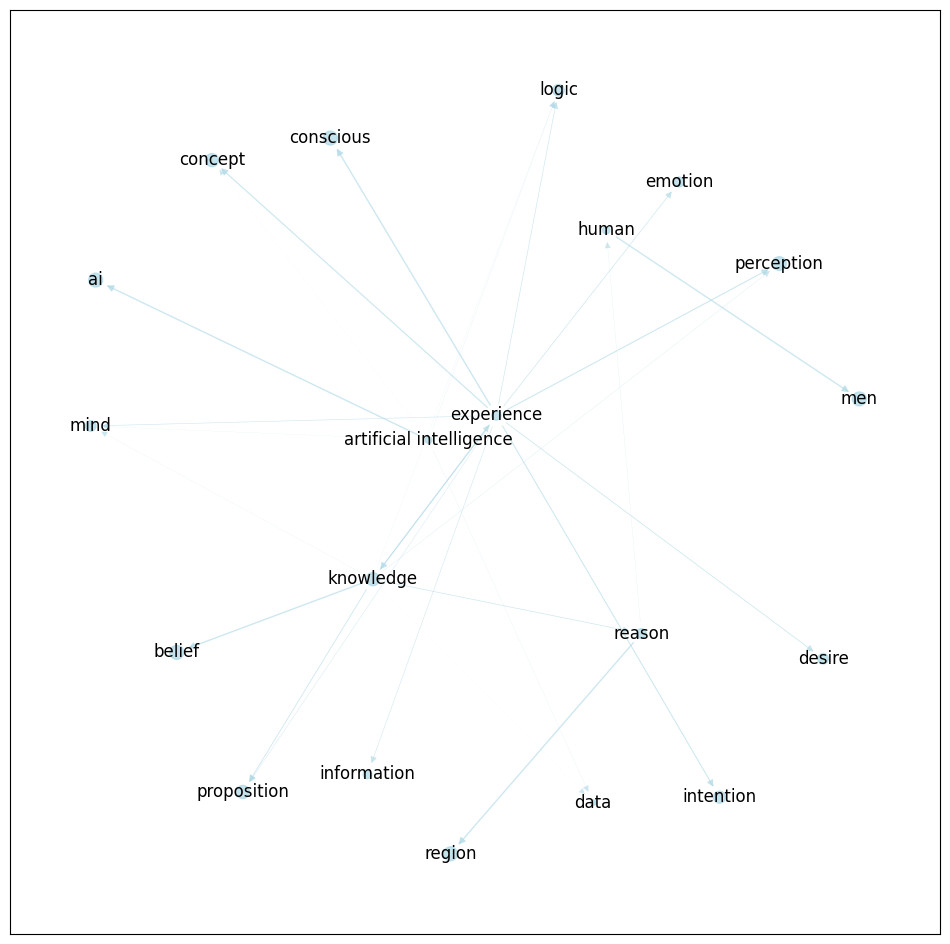

In [34]:
ng = simplify_graph(rg, 20)

create_graph(ng)
